# The N-body builder: a new approach to produce tailored to realistic N-body models

We use the pyimfit module to produce our multi-structural model. As we may want to plot each component independently, we define the components one by one. For this galaxy, we make use of 5 components to describe the galaxy: bulge, thin-disc, thick-disc, NSD and nucleus. 

The notebook is strcutured in four different sections, namely:

1. we characterise the galaxy photometrically by using PyImfit and obtaining the best 2D fit of the galaxy

2. building up the N-body model using AGAMA

3. comparing the kinematics of the model with the pPXF kinematics from the observed galaxy.

4. analysing the NSD by comparing it with the Scorza & Bender decomposition made in Morelli et al (in preparation).

## 1. 2D photometric decomposition: PyImfit

In this section we define the components to be fitted by aplying different functions present in Imfit.
in particular, we apply EdgeOnDisk function to fit the thick-disc of the galaxy and the NSD; an exponential profile
is applyed to fit the thin-disc component and both the bulge and the nucleus of the galaxy are calculated by
using Sersic profiles, with the exception of the bulge which is boxy, and for so is better to apply the Sersic_GenEllipse
function. A complete review of all these functions is widely explain in Erwin 2015.

In [2]:
import numpy as np
import pyimfit

# Defining the total model
model = pyimfit.SimpleModelDescription()

components = []
labels = ['bulge', 'thin_disk', 'thick_disk', 'NSD', 'nucleus']# We want to label each component for plotting the profiles

# Define the centre of the croped HSt image as an initial guess within a range of values, in this case +- 10 pixels.
model.x0.setValue(1068.96,   [1068,1070])
model.y0.setValue(1752.46,   [1751,1753])

# BULGE COMPONENT
components.append(pyimfit.SimpleModelDescription())
components[0].x0.setValue(1068.96,   [1068,1070])
components[0].y0.setValue(1752.49,   [1751,1753])

bulge = pyimfit.make_imfit_function('Sersic', label=labels[0])
bulge.PA.setValue(157.67, fixed=True)
bulge.ell.setValue(0.137,   [0.,0.5])
bulge.n.setValue(2., [2,2.5])
bulge.I_e.setValue(1.61, [1e-4,5])
bulge.r_e.setValue(85.69, [50,200])

components[0].addFunction(bulge)

# THICK DISC COMPONENT
components.append(pyimfit.SimpleModelDescription())
components[1].x0.setValue(1068.96,   [1068,1070])
components[1].y0.setValue(1752.49,   [1751,1753])

thin_disk = pyimfit.make_imfit_function('EdgeOnDisk', label=labels[1])
thin_disk.PA.setValue(159.8, [150,165])
thin_disk.L_0.setValue(2e-3, [1e-4,1])
thin_disk.h.setValue(264.65, [230,350])
thin_disk.n.setValue(1, fixed = True)
thin_disk.z_0.setValue(33.77, [15,70])

components[1].addFunction(thin_disk)

# THIN DISC COMPONENT
components.append(pyimfit.SimpleModelDescription())
components[2].x0.setValue(1068.96,   [1068,1070])
components[2].y0.setValue(1752.49,   [1751,1753])

thick_disk = pyimfit.make_imfit_function('EdgeOnDisk', label=labels[2])
thick_disk.PA.setValue(159.68, [158,161])
thick_disk.L_0.setValue(8.5e-4, [5e-5,5])
thick_disk.h.setValue(322.47, [270,400])
thick_disk.n.setValue(1, fixed = True)
thick_disk.z_0.setValue(82.93, [50,120])

components[2].addFunction(thick_disk)

# NSD COMPONENT
components.append(pyimfit.SimpleModelDescription())
components[3].x0.setValue(1068.96,   [1068,1070])
components[3].y0.setValue(1752.49,   [1751,1753])

''' As we base our NSD decomposition on Morelli et al. (in preparation) study, we need to constrain the parameters
    with respect to their results as to get a reliable NSD that seems like the observed one.'''

NSD = pyimfit.make_imfit_function('EdgeOnDisk', label=labels[3])
NSD.PA.setValue(157.67, [157,161])
NSD.L_0.setValue(0.48, [0.4,1.5])
NSD.h.setValue(14.52, fixed = True)
NSD.n.setValue(1., fixed = True)
NSD.z_0.setValue(5, [5,12])

components[3].addFunction(NSD)

model.addFunction(bulge)
model.addFunction(thin_disk)
model.addFunction(thick_disk)
model.addFunction(NSD)

Once the components, are defined, we may want to make an initial plot comparing the original data and the established model.

In [2]:
from astropy.io import fits
import os

file = 'FCC170_HST_croped'
intensity = fits.getdata('data/' + file + '.fits') # Open the image
s = np.shape(intensity)

# We define a set of parameters we need to apply to our fitter
filename = 'data/oversamplePSF.fits' # oversample PSF .fits file
x0, y0   = 1068, 1752 # Centre of the original HST image
ang      = np.radians(-338.0 + 90.0) # Inclination angle of the galaxy

#osampleList, PSF_image = get_PSF(filename, x0, y0)

os.environ['KMP_DUPLICATE_LIB_OK']='True'
imfit_fitter = pyimfit.Imfit(model) # Generating the 2D image of the model

# Computing the preliminar model by applying the same shape dimension as the HST image
model = imfit_fitter.getModelImage(shape = s)

We need to create the 2D images for all the pre-define components in order to establish the total flux of each component as we may want to further convert onto mass. Initiallly, we have to assume a certain mass-to-light ratio that will be revisited after the building of the N-body model.

In [3]:
from acstools import acszpt

flux = 1.7886880e-19 # HST flux conversion

# Making use of the ACS tools for the HST to calculate zeropoints of the different filters.
# To get the information of the zero points is necessary to extract the date of the observation as well as the detector and the filter
# from the ESA Science Archive webpage.
q          = acszpt.Query(date='2004-11-01', detector='WFC', filt='F850LP')
filter_zpt = q.fetch()

mod = 31.705; M_sun = 4.01 # General magnitudes of the sun in this particular filter
M_L_ratio = 1.5 # Assuming a constant mass-to-light ratio

# Getting the mass of each component
mass = np.zeros(len(components))
for i in range(len(components)):
    fit_comp   = pyimfit.Imfit(components[i])
    model_comp = fit_comp.getModelImage(shape = s)
    
    Intensity  = np.sum(model_comp)

    mag   = -2.5 * np.log10(Intensity) + filter_zpt['VEGAmag'][0].value
    Mabs  = mag - mod
    Lum   = 10**(-0.4*(Mabs - M_sun))
    print('\nMass of the '+labels[i]+': ', "{:e}".format(Lum*M_L_ratio),' M_sun')
    mass[i] = Lum*M_L_ratio

INFO:acszpt.Query:Checking inputs...
INFO:acszpt.Query:Submitting request to https://acszeropoints.stsci.edu/results_single/?date1=2004-11-01&detector=WFC&WFC_filter=F850LP


PixCteCorr is no longer supported. Please use acscte.


INFO:acszpt.Query:Parsing the response and formatting the results...



Mass of the bulge:  8.814249e+09  M_sun

Mass of the thin_disk:  6.282983e+09  M_sun

Mass of the thick_disk:  9.683120e+09  M_sun

Mass of the NSD:  6.735824e+08  M_sun


Now we want to produce the preliminar 2D images for the intensity map and our initial model. For simplicity, we create a function called 'image' for this purpose.

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


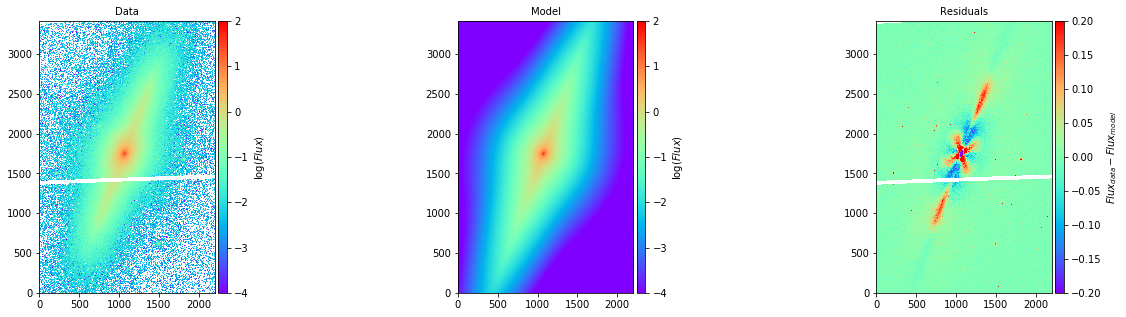

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

def image(intensity, model, chisqr=None):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax.ravel()
    im1 = ax[0].imshow(np.log10(intensity), vmin=-4, vmax=2, cmap='rainbow',origin='lower')
    im2 = ax[1].imshow(np.log10(model), vmin=-4, vmax=2, cmap='rainbow',origin='lower')
    im3 = ax[2].imshow((intensity - model), cmap='rainbow', vmin=-.2,vmax=.2,origin='lower')

    ax[0].set_title('Data', fontsize=10); ax[1].set_title('Model', fontsize=10); ax[2].set_title('Residuals', fontsize=10)

    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    #ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
    cb1 = fig.colorbar(im1, cax=cax, orientation='vertical')
    cb1.set_label(label=r'$\log(Flux)$',fontsize=10)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    #ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
    cb2 = fig.colorbar(im2, cax=cax, orientation='vertical')
    cb2.set_label(label=r'$\log(Flux)$',fontsize=10)

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    #ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
    cb3 = fig.colorbar(im3, cax=cax, orientation='vertical')
    cb3.set_label(label=r'$Flux_{data}-Flux_{model}$',fontsize=10)

    if chisqr != None:
        ax[2].annotate(r'$\chi^{2}=$'+str(chisqr),(1300,3000),(1300,3000))
    
    plt.subplots_adjust(wspace=0.5)

# Plotting the maps
image(intensity, model)

In [94]:
save_array = np.array([x,y,model.reshape(s[0]*s[1])])
np.savetxt('FCC170_imfit_model.txt',save_array.T)

As we observer from the residual map, our model fits reasonably well the data, however, there are discrepancies in the centre and along the disc of the galaxy. We do not expect the model to perfectly match the galaxy as we need to deal with a huge degree of degeneracy. Moreover, our Imfit functions must be identical to those we later will use on AGAMA to produce the N-body models. This limit our chances to get a nice fit as N-body models assume the symmetry of the total potential, nevertheless 'real galaxies have curves'. We cannot reproduce an assymetric structure, such as a warped disc, or a not perfectly aligned disc. Also the boxyness of the bulge is not reproducible. For these reasons, we do not need a perfect fit, but instead, a reasonable model.

The next function it's useful to plot the surface brightness profiles of our initial guess along major and minor axis of our model.

In [5]:
def brightness_fitting(x0,y0,data,model,comps,ang,labels):

    step = 500
    s = np.shape(data)
    x, y   = np.arange(s[1]), np.arange(s[0])
    xx, yy = np.meshgrid(x,y)
    x, y   = xx.reshape(s[0]*s[1]), yy.reshape(s[0]*s[1])
    x, y   = (x - x0)*0.05, (y - y0)*0.05
    xcord,ycord = x*np.cos(ang) - y*np.sin(ang), x*np.sin(ang) + y*np.cos(ang)
    spec_data  = data.reshape(s[0]*s[1])
    spec_model = model.reshape(s[0]*s[1])

    spec_comps = []
    for i in range(len(comps)):
        fit_comp   = pyimfit.Imfit(comps[i])
        model_comp = fit_comp.getModelImage(shape = s)
        spec_comps.append(model_comp.reshape(s[0]*s[1]))

    apertures = np.linspace(0.0,100.0,step)
    flux_data, flux_model = [], []
    for i in range(len(apertures)-1):
        idx = (ycord <= 0.1) & (ycord >= -0.1)
        xbin, ybin, spec_data_bin, spec_model_bin = xcord[idx], ycord[idx], spec_data[idx], spec_model[idx]
        idx = (xbin >= apertures[i]) & (xbin <= apertures[i+1])
        xbin, ybin, spec_data_bin, spec_model_bin = xbin[idx], ybin[idx], spec_data_bin[idx], spec_model_bin[idx]
        flux_data.append(np.sum(spec_data_bin))
        flux_model.append(np.sum(spec_model_bin))

    fig, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15,9), sharex=True)
    ax = ax.ravel()

    ax[0].plot(apertures[:-1],-2.5*np.log10(flux_data),label='data')
    ax[0].plot(apertures[:-1],-2.5*np.log10(flux_model),label='model')
    ax[2].plot(apertures[:-1],np.array(-2.5*np.log10(flux_data))-np.array(-2.5*np.log10(flux_model)),'.')

    ap_min = np.linspace(0.0,20.0,step)
    flux_data, flux_model = [], []
    for i in range(len(ap_min)-1):
        idx = (xcord <= 0.1) & (xcord >= -0.1)
        xbin, ybin, spec_data_bin, spec_model_bin = xcord[idx], ycord[idx], spec_data[idx], spec_model[idx]
        idx = (ybin >= ap_min[i]) & (ybin <= ap_min[i+1])
        xbin, ybin, spec_data_bin, spec_model_bin = xbin[idx], ybin[idx], spec_data_bin[idx], spec_model_bin[idx]
        flux_data.append(np.sum(spec_data_bin))
        flux_model.append(np.sum(spec_model_bin))

    ax[1].plot(apertures[:-1],-2.5*np.log10(flux_data))#,label='data')
    ax[1].plot(apertures[:-1],-2.5*np.log10(flux_model))#,label='model')
    ax[3].plot(apertures[:-1],np.array(-2.5*np.log10(flux_data))-np.array(-2.5*np.log10(flux_model)),'.')

    ''' We also are interested into estimate the NSD-to-total-light and compare it with Morelli et al. (in preparation) '''
    flux_comps = []
    for j in range(len(spec_comps)):
        flux_model = []
        for i in range(len(apertures)-1):
            idx = (ycord <= 0.1) & (ycord >= -0.1)
            xbin, ybin, spec_model_bin = xcord[idx], ycord[idx], spec_comps[j][idx]
            idx = (xbin >= apertures[i]) & (xbin <= apertures[i+1])
            xbin, ybin, spec_model_bin = xbin[idx], ybin[idx], spec_model_bin[idx]
            flux_model.append(np.sum(spec_model_bin))

        flux_comps.append(np.array(flux_model)) # Storing the profiles along the major-axis for each component
        ax[0].plot(apertures[:-1],-2.5*np.log10(flux_model),label=labels[j])

    for j in range(len(spec_comps)):
        flux_model = []
        for i in range(len(ap_min)-1):
            idx = (xcord <= 0.1) & (xcord >= -0.1)
            xbin, ybin, spec_model_bin = xcord[idx], ycord[idx], spec_comps[j][idx]
            idx = (ybin >= ap_min[i]) & (ybin <= ap_min[i+1])
            xbin, ybin, spec_model_bin = xbin[idx], ybin[idx], spec_model_bin[idx]
            flux_model.append(np.sum(spec_model_bin))

        ax[1].plot(apertures[:-1],-2.5*np.log10(flux_model))#,label=labels[j])

    ax[0].set_ylim(5,-8.0); ax[1].set_ylim(5,-8.0)
    ax[0].set_xscale('log'); ax[1].set_xscale('log')
    ax[2].set_xscale('log'); ax[3].set_xscale('log')
    #ax[0].set_xlim(0.0,100.0); ax[2].set_xlim(0.0,100.0)
    ax[0].legend(); ax[1].legend()

    ax[0].set_ylabel(r'$\mu (mag/arcsec^{2})$',fontsize=15); ax[1].set_ylabel(r'$\mu (mag/arcsec^{2})$',fontsize=15)
    #ax[0].set_xlabel('x (arcsec)',fontsize=15); ax[1].set_xlabel('x (arcsec)',fontsize=15)
    ax[2].set_xlabel('x (arcsec)',fontsize=15); ax[3].set_xlabel('x (arcsec)',fontsize=15)

    ax[0].tick_params(axis='x',labelsize=15); ax[0].tick_params(axis='y',labelsize=15)
    ax[1].tick_params(axis='x',labelsize=15); ax[1].tick_params(axis='y',labelsize=15)
    ax[2].tick_params(axis='x',labelsize=15); ax[2].tick_params(axis='y',labelsize=15)
    ax[3].tick_params(axis='x',labelsize=15); ax[3].tick_params(axis='y',labelsize=15)

    ax[0].set_title('Semi-major axis',fontsize=15); ax[1].set_title('Semi-minor axis',fontsize=15)

    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                        wspace=0.2, hspace=0.001)
    
    # Returning the flux within the aperture per component along with the apertures
    return flux_comps, apertures[:-1]
    ''' We also  '''

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

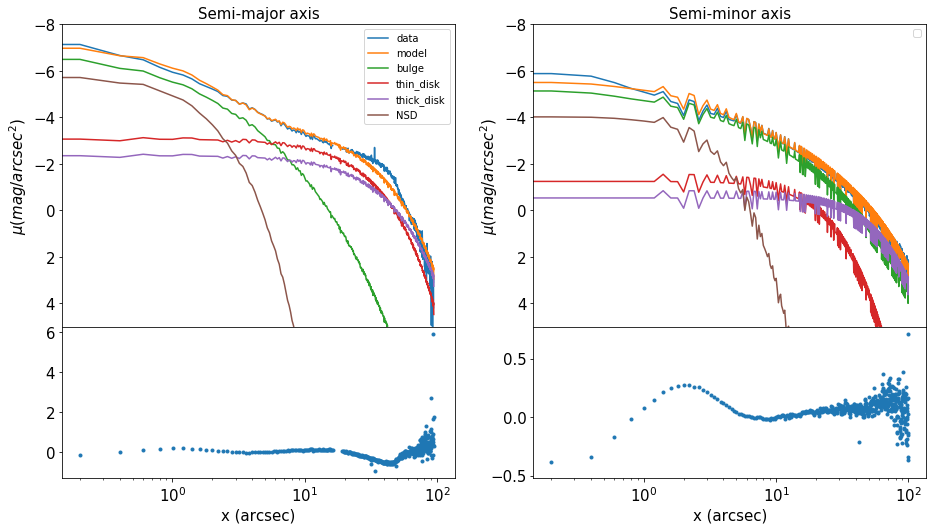

In [6]:
# Let's plot the profiles... it could take a while
flux_comps, apertures = brightness_fitting(x0,y0,intensity,model,components,ang,labels)

The plots above show the surface brightness of data, total model, and each component along the major axis of the galaxy (panels on the top) and the minor axis (panels on the bottom). We observe a reasonable residuals for this fit except in the outer parts of the galaxy, at about ~100 arcsec. This is a reasonable model to be used in AGAMA to produce a pure N-body model, however, let's try to improve the fit a bit more.

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


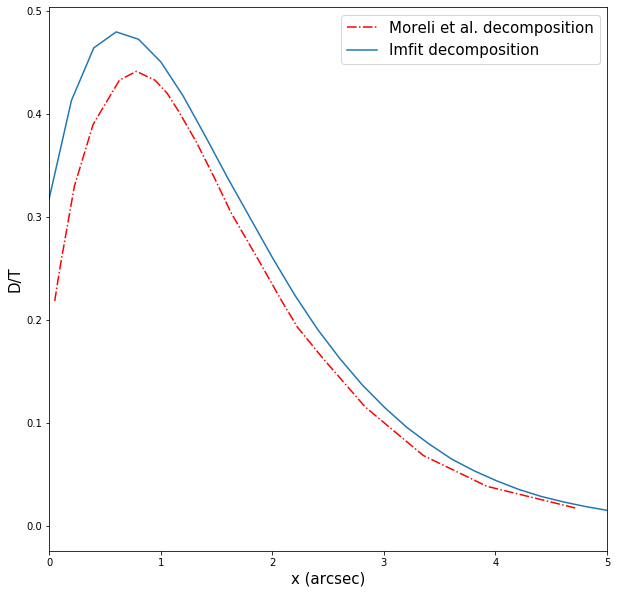

In [84]:
plt.figure(figsize=(10,10))

# Recovering the disc-to-total-light contribution of the NSD as calculated in Morelli et al. (in preparation)
file = np.loadtxt('data/Morelli_D_T.txt')
plt.plot(file[:,0],file[:,1],'r-.',label='Moreli et al. decomposition')

# We plot OUR D/T contribution by dividing the light ratio between the NSD and the sum of the other components
plt.plot(apertures,flux_comps[3]/(flux_comps[0]+flux_comps[1]+flux_comps[2]),label='Imfit decomposition')
plt.xlim(0,5); plt.xlabel('x (arcsec)', fontsize=15); plt.ylabel('D/T', fontsize=15)
plt.legend(fontsize=15)

This quick experiment allows us to contrain the light (mass) of the NSD, so according to this plot, and as regards of the model, the mass of the NSD is about $\sim 2.75\times10^{8}\;M_{\odot}$.

As regards of PyImfit, to use it as a fiter of two different datasets (data and model), we need to mask all those pixels that are negative, or NaNs. Also, if there would be a star or a foreground/background galaxy in our image, it has need to be masked as well.

In [50]:
# Producing the error map as the SQRT of the signal. This is a reasonable apprroach for Poissonian noise.
signal = np.copy(intensity)
signal[signal < 0.0] = 0.0
signal[np.isnan(signal)] = 0.0
errors = np.sqrt(signal)

# Avoiding those regions with NaNs or Inf
mask = ~np.isfinite(intensity)

#imfit_fitter.loadData(intensity, psf_oversampling_list=osampleList, mask = mask, error = errors)

# WARNING: the fitting routine could take a lot of time depending on the similarity of the model respect to the data. It is
# important to start with a reasonable model in order to decrease the computational time
imfit_fitter.fit(intensity, mask = mask, verbose = 1, error = errors) # Fitting the image
bestfit_parameters = imfit_fitter.getRawParameters() # Getting the bestfit parameters

if imfit_fitter.fitConverged is True:
    bestfit_params = imfit_fitter.getRawParameters()
    print("Best-fit parameter values:", bestfit_params)
    print("Fit converged: chi^2 = {0}, reduced chi^2 = {1}".format(imfit_fitter.fitStatistic,
        imfit_fitter.reducedFitStatistic))
    
# We want to save the parameter file of the bestfit
np.savetxt('parameterfile.txt', bestfit_params)
print('Parameter file saved as parameterfile.txt')

''' The order of the parameters in the parameterfile is the same as the ones defined in 
    the models, i.e. x0, y0, (bulge) PA, ell, c0, ..., (thick-disc)'''

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


Best-fit parameter values: [1.06889318e+03 1.75246861e+03 1.57670000e+02 1.37461548e-01
 2.00000000e+00 1.61365648e+00 8.56918931e+01 1.59726299e+02
 2.02409245e-03 2.64651044e+02 1.00000000e+00 3.37723044e+01
 1.59783204e+02 8.52276859e-04 3.22469313e+02 1.00000000e+00
 8.29258950e+01 1.60048522e+02 4.00000000e-01 1.45200000e+01
 1.00000000e+00 5.00000000e+00]
Fit converged: chi^2 = 43454.77814837046, reduced chi^2 = 0.00786969759749256
Parameter file saved as parameterfile.txt


' The order of the parameters in the parameterfile is the same as the ones defined in \n    the models, i.e. x0, y0, (bulge) PA, ell, c0, ..., (thick-disc)'

Once we fit our data, let's re-plot the new model to compare how much we have improved the fit.

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


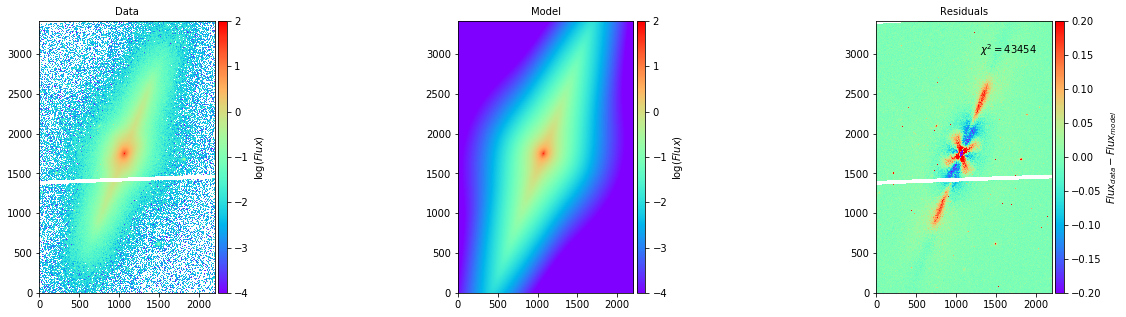

In [51]:
# Model image
model = imfit_fitter.getModelImage()
# Total flux and individual fluxes of the model
(totalFlux, componentFluxes) = imfit_fitter.getModelFluxes()

# 2D images of fitted model
image(intensity, model, chisqr=int(imfit_fitter.fitStatistic))

It is necessary to convert from HST pixel units to kpc (1 px = 0.05 arcsec)

In [1]:
distance   = 19.57 * 1000 # Distance towards the galaxy in kpc
arcsec2kpc = distance * np.tan(np.pi / 648000)

''' In order to initialise AGAMA model, place these parameters like they output on consistent_params.ini.
    These set of parameters have to be written on their corresponding AGAMA param, and also on the DFs section if applies.'''

print("\n\033[1;37mConverting from HST scales to kpc \033[0m")
print('Bulge Re: ',bestfit_params[6]*0.05*arcsec2kpc)
print('Thin-disc R0: ',bestfit_params[9]*0.05*arcsec2kpc)
print('Thin-disc H: ',bestfit_params[11]*0.05*arcsec2kpc)
print('Thick-disc R0: ',bestfit_params[14]*0.05*arcsec2kpc)
print('Thick-disc H: ',bestfit_params[16]*0.05*arcsec2kpc)
print('NSD R0: ',bestfit_params[19]*0.05*arcsec2kpc)
print('NSD H: ',bestfit_params[21]*0.05*arcsec2kpc)

Rthin = bestfit_params[9]*0.05*arcsec2kpc; Rthick = bestfit_params[14]*0.05*arcsec2kpc; RNSD = bestfit_params[19]*0.05*arcsec2kpc
sigma_thin  = mass[1]/(2*np.pi*Rthin*Rthin)
sigma_thick = mass[2]/(2*np.pi*Rthick*Rthick)
sigma_NSD   = mass[3]/(2*np.pi*RNSD*RNSD)

print("\033[1;37mSurface densities of disc components \033[0m")
print('Sigma_{0,thin-disc}=%.3g' % sigma_thin)
print('Sigma_{0,thick-disc}=%.3g' % sigma_thick)
print('Sigma_{0,NSD}=%.3g' % sigma_NSD)

Mbh = 0.49*1.0e9*((mass[0]/1.0e11)**1.17) # M-sigma relation
print("\033[1;37mTotal masses of spheroidal components \033[0m")
print('Central SMBH mass:%.3g' % Mbh)
print('Bulge mass:%.3g' % mass[0])

print("\033[1;37mSersic indexes and axi-symmetry of the bulge\033[0m")
print('n_bulge=',bestfit_params[4])
print('axisRatioZ=',1-bestfit_params[3])

NameError: name 'np' is not defined

It doesn't look the residual map has varied, so in this case the fit is OK and we start to produce the N-body model.

## 2. Building up a tailored to realistic N-body model: the galaxy model architecture AGAMA

The previously obtained parameter file is the tool we will use to extract the necessary parameters to initialise AGAMA and produce a N-body model of our galaxy. We need to keep in mind the units AGAMA uses to produce a N-body model: v ~ 1 km/s, L ~ 1 kpc, M ~ 1 $M_{\odot}$. By acomplished this last remark, we need to convert from Hubble ACS pixels to kpc, and from total flux-per-component to total mass-per-component. In particular, we can easily convert to kpc by simply know the distance towards the galaxy (i.e. about 21 Mpc). We already obtained the mass of the components so we already have this step done.

The conversion from HST pixels to the physical units of kpc is given by multiplying all distances (scale radius, exponential radius, etc.) by a factor $0.005\;px\:kpc^{-1}$. As regards of this conversion factor, the effective radius of the bulge in pixel units is $R_{e}=83.42\:px$, so by using the aforementioned factor we get $R_{e}=420\:pc$. For the mass, we consider the calculations showed above, however, there is a chance that the kinematics does not reproduce the observed one, in this case, we need to re-fit the mass-to-light ratio to a more convenient factor and consider the new masses to write them on the consistent_params.ini file.

AGAMA works on the basis of action-based DFs, a complete description of the code can be found on the original AGAMA paper (Vasiliev 2019). In essence, we need to define three different sets of parameters in the paremeter file (found in data/consistent_params.ini):

1. Potentials/densities: based on our obtained Imfit parameters. The functions has to be consistent to those chosen in Imfit. For this purpose, we choose Sersic profiles for spheroidal components, Disk profiles for disc components, and Hernquist for the central supermassive black hole and the dark matter halo of the galaxy.

2. Action-based distribution functions: based on similar parameters as the ones used to produce the densities but also adding the action-angle parameters that govern the stepness or sharpness of the functions. For the spherical components the easiest choice is select the 'QuasiSpherical' DFs, as they are the most similar ones to the chosen potentials. For disc components we choose the 'QuasiIsothermal' DFs so we require to define the parameters fo the circularity, angular momentum and such. These can be obtained from the kinematics maps showed in Pinna et al. 2019a.

3. SelfConsistentModel parameters (SCM): these parameters are used to build up the grid over the calculation is done.

In [43]:
# initialise the AGAMA module
import agama
from configparser import RawConfigParser  # python 3

# Convert dictionary data values to floats
def keysToFloat(data_list):
    for keys in data_list.keys():
        if (keys == 'type') | (keys == 'useactioninterpolation'):
            continue
        else:
            data_list[keys] = float(data_list[keys])
    return data_list

# Setting the units to M=1 solar mass, v=1 km/s, d=1 kpc
agama.setUnits(mass=0.99995, length=1.0, velocity=1)

# Reading the initial parameters for the different components
iniFileName = "data/consistent_params.ini"
ini = RawConfigParser()

ini.read(iniFileName)

# Reading the number of particles per component
NumParts      =  keysToFloat(dict(ini.items("Particles per model")))

# Potential parameters
iniPotenDM         = keysToFloat(dict(ini.items("Potential dark halo")))
iniPotenBulge      = keysToFloat(dict(ini.items("Potential bulge")))
iniPotenDisk       = keysToFloat(dict(ini.items("Potential thin disk")))
iniPotenThick      = keysToFloat(dict(ini.items("Potential thick disk")))
iniPotenNSD        = keysToFloat(dict(ini.items("Potential NSD")))
iniPotenBH         = keysToFloat(dict(ini.items("Potential BH")))

# DF parameters
iniDisk       = keysToFloat(dict(ini.items("DF thin disk")))
iniThick       = keysToFloat(dict(ini.items("DF thick disk")))
iniNSD        = keysToFloat(dict(ini.items("DF NSD")))

# SCM parameters
iniSCMBulge   = keysToFloat(dict(ini.items("SelfConsistentModel bulge")))
iniSCMDisk    = keysToFloat(dict(ini.items("SelfConsistentModel thin disk")))
iniSCMThick   = keysToFloat(dict(ini.items("SelfConsistentModel thick disk")))
iniSCMDM      = keysToFloat(dict(ini.items("SelfConsistentModel dark halo")))
iniSCMNSD     = keysToFloat(dict(ini.items("SelfConsistentModel NSD")))
iniSCM        = keysToFloat(dict(ini.items("SelfConsistentModel")))

# Defining the npart array
npart = np.array([0,0,0,0,0,0])
for i in NumParts:
    if i == 'type1':
        npart[1] = int(NumParts[i])
    elif i == 'type2':
        npart[2] = int(NumParts[i])
    elif i == 'type3':
        npart[3] = int(NumParts[i])
    elif i == 'type4':
        npart[4] = int(NumParts[i])
    elif i == 'type5':
        npart[5] = int(NumParts[i])
    elif i == 'type0':
        npart[0] = int(NumParts[i])

# Initialising the SCM
model = agama.SelfConsistentModel(**iniSCM)

# plotting the density profiles
print('Bulge: ', iniPotenBulge)
print('Thin-disc: ', iniPotenDisk)
print('Thick-disc: ', iniPotenThick)
print('NSD: ', iniPotenNSD)
print('DM halo: ', iniPotenBulge)
print('Central SMBH: ', iniPotenBH)

Bulge:  {'type': 'Sersic', 'mass': 7630000000.0, 'scaleradius': 0.4, 'sersicindex': 2.24, 'axisratioz': 0.8}
Thin-disc:  {'type': 'Disk', 'surfacedensity': 660000000.0, 'scaleradius': 1.253, 'scaleheight': -0.16}
Thick-disc:  {'type': 'Disk', 'surfacedensity': 676000000.0, 'scaleradius': 1.538, 'scaleheight': -0.39}
NSD:  {'type': 'Disk', 'surfacedensity': 20200000000.0, 'scaleradius': 0.069, 'scaleheight': -0.024}
DM halo:  {'type': 'Sersic', 'mass': 7630000000.0, 'scaleradius': 0.4, 'sersicindex': 2.24, 'axisratioz': 0.8}
Central SMBH:  {'type': 'Plummer', 'mass': 24100000.0, 'scaleradius': 0.001}


Defining the initial densities based on Imfit:

In [44]:
# initial guess for the potential
DensDisk  = agama.Density(**iniPotenDisk)
DensThick = agama.Density(**iniPotenThick)
DensBulge = agama.Density(**iniPotenBulge)
DensDark  = agama.Density(**iniPotenDM)
DensNSD   = agama.Density(**iniPotenNSD)
PotenBH   = agama.Potential(**iniPotenBH)

print("Bulge with mass %g" % DensBulge.totalMass())
print("Thin-disc with mass %g" % DensDisk.totalMass())
print("Thick-disc with mass %g" % DensThick.totalMass())
print("NSD with mass %g" % DensNSD.totalMass())
print("DM halo with mass %g" % DensDark.totalMass())
print("Central SMBH with mass %g" % PotenBH.totalMass())

Bulge with mass 7.63144e+09
Thin-disc with mass 6.51061e+09
Thick-disc with mass 1.00471e+10
NSD with mass 6.04266e+08
DM halo with mass 2.56e+11
Central SMBH with mass 2.41e+07


Now we are able to start defining the self-consistent model by iterate the components each one. This method tries to solve the Poisson's equation by combining a multipole potential based on a combination of all the components.

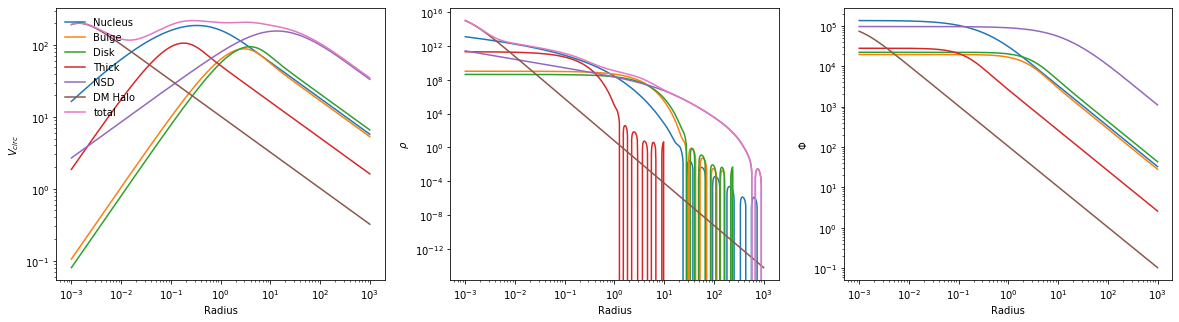

In [45]:
model.components.append(agama.Component(density=DensBulge,  disklike=False))
model.components.append(agama.Component(density=DensDisk,   disklike=True))
model.components.append(agama.Component(density=DensThick,   disklike=True))
model.components.append(agama.Component(density=DensNSD,    disklike=True))
model.components.append(agama.Component(density=DensDark,   disklike=False))
model.components.append(agama.Component(potential=PotenBH, disklike=False))

# Iterating the model
model.iterate()

# Let's do some plots of the initialise model
def plotprofiles():
    pot_list = []
    for comp in model.components:
        pot = comp.getPotential()
        if pot is None:
            pot = agama.Potential(density=comp.getDensity(), type='Multipole', lmax=32)  # quick-and-dirty
        pot_list.append(pot)
    potvis = agama.Potential(*pot_list)
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax = ax.ravel()
    # Defining the spatial grid
    r = np.logspace(-3,3,1000)
    points = np.column_stack((r, r*0, r*0)) # a N x 3 array
    
    force, deriv = potvis.forceDeriv(points) # force and first derivative of the force
    labels = ['Nucleus','Bulge','Disk','Thick','NSD','DM Halo','BH']
    
    for i in range(len(potvis)):
        force, deriv = potvis[i].forceDeriv(points)
        ax[0].plot(r, np.sqrt(-r*potvis[i].force(points)[:,0]),label=labels[i]) # Plotting rotation curves as derivative of the potential -r*der(phi)/der(r)
        ax[1].plot(r, potvis[i].density(points), label=labels[i]) # Density profiles
        ax[2].plot(r, -potvis[i].potential(points), label=labels[i]) # Potential
    ax[0].plot(r, np.sqrt(-r*potvis.force(points)[:,0]), label='total')
    ax[1].plot(r, potvis.density(points));
    ax[0].set_xscale('log');ax[0].set_yscale('log');#ax[0].set_ylim(1,1000)
    ax[1].set_xscale('log');ax[1].set_yscale('log');#ax[1].set_ylim(1,1e12)
    ax[2].set_xscale('log');ax[2].set_yscale('log');#ax[2].set_ylim(1,1e6)
    ax[0].set_xlabel('Radius'); ax[0].set_ylabel(r'$V_{circ}$')
    ax[1].set_xlabel('Radius'); ax[1].set_ylabel(r'$\rho$')
    ax[2].set_xlabel('Radius'); ax[2].set_ylabel(r'$\Phi$')
    ax[0].legend(loc='upper left',frameon=False)
    plt.draw()

plotprofiles()

So as we way see the centre of the potential is domained by the SMBH, the nucleus and the bulge. The outskirts of the model are dominated by the thin-disc and thick-disc and large scale distances by the DM halo, as we may expect from an observational rotation curve of a galaxy.

Now we compute the initial approach of the action-based DFs by using the total generated multipole potential (that we initially iterated) along with the pre-established parameters we use to constrain our DFs. For the spheroidal components, we just simply need to apply the specific density of each component and we update the components

In [46]:
# DISC COMPONENTS DFS
DFdisk  = agama.DistributionFunction(potential=model.potential, **iniDisk)
DFthick = agama.DistributionFunction(potential=model.potential, **iniThick)
DFNSD   = agama.DistributionFunction(potential=model.potential, **iniNSD)

# SPHEROIDAL COMPONENTS DFS
DFbulge = agama.DistributionFunction(potential=model.potential, density=DensBulge, type='QuasiSpherical')
DFdark  = agama.DistributionFunction(potential=model.potential, density=DensDark , type='QuasiSpherical')

model.components[0] = agama.Component(df=DFbulge, disklike=False, **iniSCMBulge)
model.components[1] = agama.Component(df=DFdisk,  disklike=True,  **iniSCMDisk)
model.components[2] = agama.Component(df=DFthick,  disklike=True,  **iniSCMThick)
model.components[3] = agama.Component(df=DFNSD,   disklike=True,  **iniSCMNSD)
model.components[4] = agama.Component(df=DFdark,  disklike=False, **iniSCMDM)

In [47]:
# Let's plot the masses of the components by calculated using the DFs
print("\033[1;33m**** STARTING ITERATIVE MODELLING ****\033[0m\nMasses (computed from DF): " \
    "Mbulge=%g, MNSD=%g, Mthin=%g, Mthick=%g, MDM=%g" % (DFbulge.totalMass(), DFNSD.totalMass(),DFdisk.totalMass(),DFthick.totalMass(),DFdark.totalMass()))

# print some diagnostic information after each iteration
def printoutInfo(model, iteration):
    names=['Bulge','Disk','Thick','NSD','DM Halo','BH']
    print("Potential at origin=-(%g)^2, total mass=%g" % \
        ((-model.potential.potential(0,0,0))**0.5, model.potential.totalMass()))
    writeRotationCurve("./diagnostic/rotcurve_iter"+str(iteration), model.potential)
    for i,c in enumerate(model.components):
        d = c.getDensity()
        if d is None: d = c.getPotential()
        print("%s %s total mass: %.3g, rho(R=1,z=0): %.3g" % (c, names[i], d.totalMass(), d.density(1,0,0)))
        d.export('./diagnostic/density'+names[i]+'_iter'+str(iteration))

# write out the rotation curve for the entire model and per component
def writeRotationCurve(filename, potentials):
    potentials.export(filename+'.pot')
    radii = np.logspace(-4, 2, 201)
    xyz   = np.column_stack((radii, radii*0, radii*0))
    vcomp = np.column_stack([(-potential.force(xyz)[:,0] * radii)**0.5 for potential in potentials])
    vtot  = np.sum(vcomp**2, axis=1)**0.5
    np.savetxt(filename, np.column_stack((radii, vtot, vcomp)), fmt="%.6g", header="radius\tv_circ")        
        
# do a few more iterations to obtain the self-consistent density profile for both disks
# WARNING: this step will take a while! Be patient my friend ;-)
for iteration in range(1,6):
    print("\033[1;37mStarting iteration #%d\033[0m" % iteration)
    model.iterate()
    printoutInfo(model, iteration)

**** STARTING ITERATIVE MODELLING ****
Masses (computed from DF): Mbulge=9.53928e+09, MNSD=5.90479e+08, Mthin=6.48271e+09, Mthick=9.94491e+09, MDM=2.56001e+11
Starting iteration #1
Potential at origin=-(650.621)^2, total mass=2.82962e+11
Spheroidal component Bulge total mass: 9.58e+09, rho(R=1,z=0): 2.91e+08
Disklike component Disk total mass: 6.48e+09, rho(R=1,z=0): 4.72e+08
Disklike component Thick total mass: 9.95e+09, rho(R=1,z=0): 2.13e+08
Disklike component NSD total mass: 5.91e+08, rho(R=1,z=0): 1.31e+05
Spheroidal component DM Halo total mass: 2.56e+11, rho(R=1,z=0): 2.25e+08
Static potential component BH total mass: 2.41e+07, rho(R=1,z=0): 5.75
Starting iteration #2
Potential at origin=-(658.514)^2, total mass=2.84002e+11
Spheroidal component Bulge total mass: 9.58e+09, rho(R=1,z=0): 2.77e+08
Disklike component Disk total mass: 6.48e+09, rho(R=1,z=0): 5e+08
Disklike component Thick total mass: 9.95e+09, rho(R=1,z=0): 2.27e+08
Disklike component NSD total mass: 5.91e+08, rho(R=

To guarantee the model converges, we can check how the mass of different components varies in each iteration. If the mass doesn't change that much from one to the other, it means the model has converged.

Finally we plot the last version of our profiles from the updated potential as well as the Toomre parameter $Q$ for the thin-disc (we can compute the others by simply changing the DF).

Computing disk density and velocity profiles
Computing surface density
Computing 3d density and velocity dispersion
Computing vertical density profiles


/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Computing velocity distributions


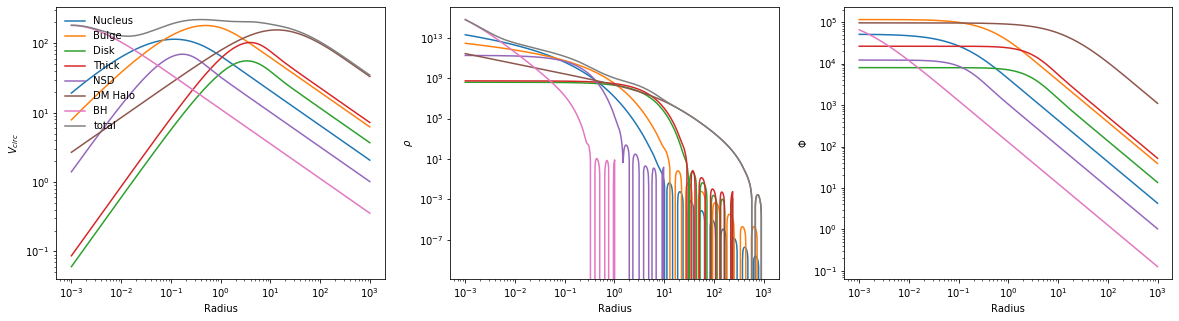

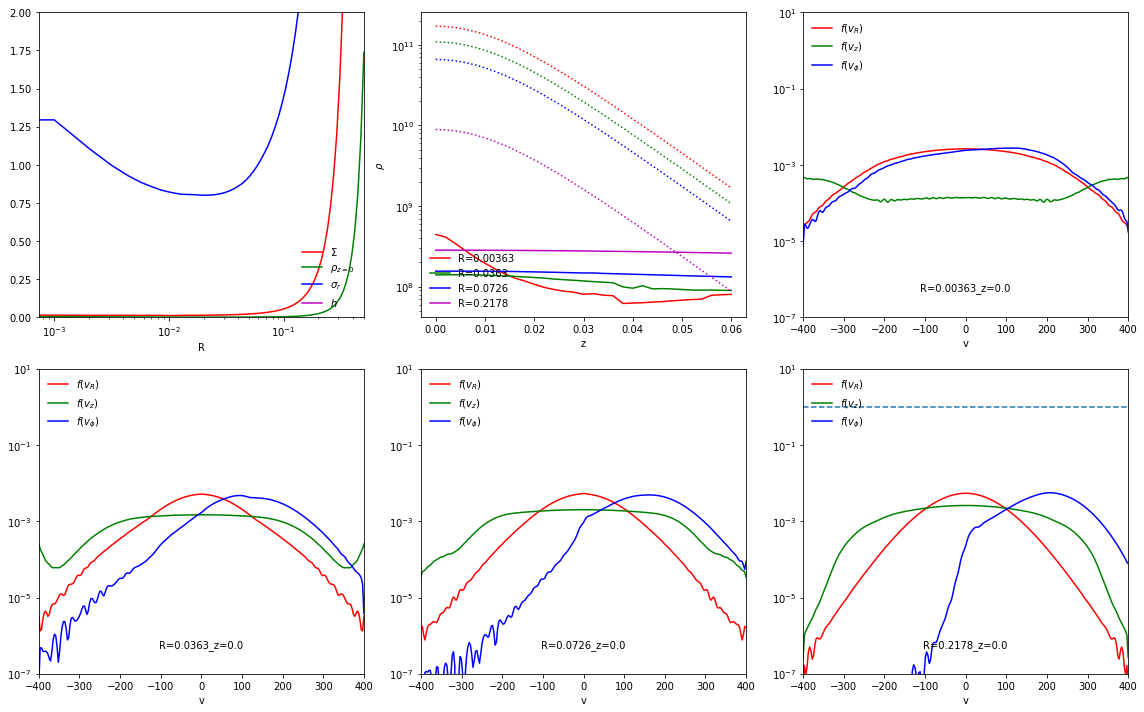

In [43]:
# Plot the profiles again
plotprofiles()

def plottoomre():
    # the remaining part computes and plots various diagnostics
    print("\033[1;33mComputing disk density and velocity profiles\033[0m")
    ax=plt.subplots(2, 3, figsize=(16,10))[1].reshape(-1)
    
    # take only the disk component
    modelDisk = agama.GalaxyModel(potential=model.potential, df=DFdisk, af=model.af)
    
    # radial grid for computing various quantities in the disk plane
    Sigma0 = float(iniPotenNSD["surfacedensity"])
    Rdisk  = float(iniPotenNSD["scaleradius"])
    Hdisk  = abs(float(iniPotenNSD["scaleheight"]))
    sigmar0= float(iniNSD["sigmar0"])
    rsigmar= float(iniNSD["rsigmar"])
    R   = agama.nonuniformGrid(60, 0.001, 0.5)
    xyz = np.column_stack((R, R*0, R*0))
    
    print("Computing surface density")
    Sigma,rmsh,rmsv   = modelDisk.projectedMoments(R)
    
    print("Computing 3d density and velocity dispersion")
    rho,vel,sigma = modelDisk.moments(xyz,vel=True)
    force, deriv = model.potential.forceDeriv(xyz)
    kappa = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
    plt.figure(2,figsize=(10,10))
    ToomreQ = sigma[:,0]**0.5 * kappa / (3.36*Sigma*4.3e-6) # CHECK THIS EQUATION
    plt.axhline(1.0,linestyle='dashed')
    plt.plot(R,ToomreQ); plt.xlim(0,0.2)
    np.savetxt("diagnostic/disk_plane",
        np.column_stack((R, Sigma, rho, rmsh, sigma[:,0]**0.5, (sigma[:,2]-vel**2)**0.5, \
        sigma[:,1]**0.5, vel, ToomreQ)),
        header="R Sigma rho(R,z=0) height sigma_R sigma_phi sigma_z v_phi ToomreQ", fmt="%.6g")
    ax[0].plot(R, Sigma / (Sigma0 * np.exp(-R/Rdisk)), 'r-', label=r'$\Sigma$')
    ax[0].plot(R, rho   / (Sigma0 * np.exp(-R/Rdisk) * 0.25/Hdisk), 'g-', label=r'$\rho_{z=0}$')
    ax[0].plot(R, sigma[:,0]**0.5 / (sigmar0 * np.exp(-R/rsigmar)), 'b-', label=r'$\sigma_r$')
    ax[0].plot(R, rmsh / (1.8*Hdisk), 'm-', label=r'$h$')
    ax[0].set_xscale("log")
    ax[0].set_xlim(R[0],R[-1])
    ax[0].set_xlabel("R")
    ax[0].set_ylim(0,2)
    ax[0].legend(loc='lower right', frameon=False)
    
    # vertical grid for density
    print("Computing vertical density profiles")
    z = np.linspace(0, 6*Hdisk, 31)
    R = np.array([0.05, 0.5, 1.0, 3.0]) * Rdisk
    xyz = np.column_stack((np.tile(R, len(z)), np.zeros(len(R)*len(z)), np.repeat(z, len(R))))
    rho = modelDisk.moments(xyz, vel2=False).reshape(len(z), len(R))
    np.savetxt("vertical_density", np.column_stack((z, rho)), fmt="%.6g",
        header="z\\R:\t" + "\t".join(["%.4g" % r for r in R]))
    
    colors=['r','g','b','m']
    for i,r in enumerate(R):
        ax[1].plot(z, rho[:,i], '-', c=colors[i], label='R='+str(r))
        rho_init = Sigma0 * np.exp(-r/Rdisk) / Hdisk / (np.exp(-z/2/Hdisk) + np.exp(z/2/Hdisk))**2
        ax[1].plot(z, rho_init, ':', c=colors[i])
    ax[1].set_xlabel('z')
    ax[1].set_ylabel(r'$\rho$')
    ax[1].set_yscale('log')
    ax[1].legend(loc='lower left', frameon=False)
    
    # grid for computing velocity distributions
    print("Computing velocity distributions")
    z = np.array([0, 2*Hdisk])
    xyz = np.column_stack((np.tile(R, len(z)), np.zeros(len(R)*len(z)), np.repeat(z, len(R))))
    # create grids in velocity space for computing the spline representation of VDF (optional)
    # range: 0.75 v_escape from the galactic center (excluding the central BH potential)
    v_max = 400 #0.75 * (-2 * (model.potential.potential(0,0,0)-model.potential[0].potential(0,0,0)))**0.5
    gridv = np.linspace(-v_max, v_max, 101)  # for simplicity, use the same grid for all dimensions
    # compute the distributions (represented as cubic splines)
    splvR, splvz, splvphi = modelDisk.vdf(xyz, gridv, gridv, gridv)
    # output f(v) at a different grid of velocity values
    gridv = np.linspace(-v_max, v_max, 251)
    for i,p in enumerate(xyz):
        np.savetxt("diagnostic/veldist_R="+str(p[0])+"_z="+str(p[2]),
            np.column_stack((gridv, splvR[i](gridv), splvz[i](gridv), splvphi[i](gridv))),
            fmt="%.6g", delimiter="\t", header="V\tf(V_R)\tf(V_z)\tf(V_phi) [1/(km/s)]")
        if i<len(ax)-2:
            ax[i+2].plot(gridv, splvR  [i](gridv), 'r-', label='$f(v_R)$')
            ax[i+2].plot(gridv, splvz  [i](gridv), 'g-', label='$f(v_z)$')
            ax[i+2].plot(gridv, splvphi[i](gridv), 'b-', label='$f(v_\phi)$')
            ax[i+2].set_xlabel('v')
            ax[i+2].set_yscale('log')
            ax[i+2].legend(loc='upper left', frameon=False)
            ax[i+2].set_xlim(-v_max, v_max)
            ax[i+2].set_ylim(1e-7,10)
            ax[i+2].text(0, 5e-7, "R="+str(p[0])+"_z="+str(p[2]), ha='center')
    plt.tight_layout()
    plt.show()
    
# Toomre parameter
plottoomre()

Finally, with all the ingredients we can sample the DFs in order to populate with particles the phase-space and get our N-body model. We have created the N-body file in hdf5 format, as it is a very powerful format type to use on different treecodes, as Gizmo or Gadget.

In [48]:
# Defining each particle type as a dictionary
def create_type(model, dictionary, parts, type):
    print(parts)

    posvel, mass = model.sample(parts)

    dictionary[type] = {'Coordinates':posvel[:,:3], 'Velocities':posvel[:,3:],
    'Masses':mass, 'ParticleIDs':np.arange(1,len(mass)+1) }

    return dictionary

# HDF5 file writing
def hdf5File(fname,directory,PartType,npart):

    import h5py
    fname = directory+fname+'.hdf5'
    if os.path.exists(fname):
        os.remove(fname)

    file = h5py.File(fname,'w')

    # now we make the Header - the formatting here is peculiar, for historical (GADGET-compatibility) reasons
    h = file.create_group("Header");
    # here we set all the basic numbers that go into the header
    # (most of these will be written over anyways if it's an IC file; the only thing we actually *need* to be 'correct' is "npart")
    h.attrs['NumPart_ThisFile'] = npart; # npart set as above - this in general should be the same as NumPart_Total, it only differs
                                         #  if we make a multi-part IC file. with this simple script, we aren't equipped to do that.
    h.attrs['NumPart_Total'] = npart; # npart set as above
    h.attrs['NumPart_Total_HighWord'] = 0*npart; # this will be set automatically in-code (for GIZMO, at least)
    h.attrs['MassTable'] = np.zeros(6) #np.array([0,0,Mh/npart[2],Mb/npart[3],0,0]) #np.zeros(6); # these can be set if all particles will have constant masses for the entire run. however since
                                        # we set masses explicitly by-particle this should be zero. that is more flexible anyways, as it
                                        # allows for physics which can change particle masses
    ## all of the parameters below will be overwritten by whatever is set in the run-time parameterfile if
    ##   this file is read in as an IC file, so their values are irrelevant. they are only important if you treat this as a snapshot
    ##   for restarting. Which you shouldn't - it requires many more fields be set. But we still need to set some values for the code to read
    h.attrs['Time'] = 0.0;  # initial time
    h.attrs['Redshift'] = 0.0; # initial redshift
    h.attrs['BoxSize'] = 100; # box size
    h.attrs['NumFilesPerSnapshot'] = 1; # number of files for multi-part snapshots
    h.attrs['Omega0'] = 1.0; # z=0 Omega_matter
    h.attrs['OmegaLambda'] = 0.0; # z=0 Omega_Lambda
    h.attrs['HubbleParam'] = 1.0; # z=0 hubble parameter (small 'h'=H/100 km/s/Mpc)
    h.attrs['Flag_Sfr'] = 0; # flag indicating whether star formation is on or off
    h.attrs['Flag_Cooling'] = 0; # flag indicating whether cooling is on or off
    h.attrs['Flag_StellarAge'] = 0; # flag indicating whether stellar ages are to be saved
    h.attrs['Flag_Metals'] = 0; # flag indicating whether metallicity are to be saved
    h.attrs['Flag_Feedback'] = 0; # flag indicating whether some parts of springel-hernquist model are active
    h.attrs['Flag_DoublePrecision'] = 0; # flag indicating whether ICs are in single/double precision
    h.attrs['Flag_Entropy_ICs'] = 0; # flag indicating extra options for ICs
    ## ok, that ends the block of 'useless' parameters

    for i in PartType:
        numb = int(i[-1])
        p    = file.create_group(i)
        p.create_dataset("Coordinates",data=np.array(PartType[i]['Coordinates'], dtype=np.float32))
        p.create_dataset("Velocities",data=np.array(PartType[i]['Velocities'], dtype=np.float32))
        p.create_dataset("ParticleIDs",data=np.array(np.arange(np.sum(npart[:numb]),np.sum(npart[:numb+1]))+1, dtype=np.int32))
        p.create_dataset("Masses",data=np.array(PartType[i]['Masses'], dtype=np.float32))

    file.close()
    print('File saved in ',fname)

These two functions above allows to create the different particle type arrays with positions, velocities, masses per particles, and particle IDs, and write the arrays into a HDF5 file.

In [49]:
# Creating a dictionary to store the components
PartType = {}

# now create genuinely self-consistent models of both components,
# by drawing positions and velocities from the DF in the given (self-consistent) potential
# ----------------------------------------------------
print("Sampling DM DF")
PartType = create_type(agama.GalaxyModel(potential=model.potential, df=DFdark, af=model.af), PartType, int(npart[1]), 'PartType1')

# ----------------------------------------------------
print("Sampling disk component")
PartType = create_type(agama.GalaxyModel(potential=model.potential, df=DFdisk, af=model.af), PartType, int(npart[2]), 'PartType2')

''' Including the Nucleus in the same particle type as bulge. '''

# ----------------------------------------------------
print("Sampling bulge")
PartType = create_type(agama.GalaxyModel(potential=model.potential, df=DFbulge, af=model.af), PartType, (int(npart[3])), 'PartType3')

# ----------------------------------------------------
print("Sampling NSD DF with central SMBH")
PartType = create_type(agama.GalaxyModel(potential=model.potential, df=DFNSD, af=model.af), PartType, int(npart[4]), 'PartType4')
coords = PartType['PartType4']['Coordinates']; vels = PartType['PartType4']['Velocities']; mass = PartType['PartType4']['Masses']

npart[0] = 0; npart[4] = np.copy(int(npart[4]+1))
pos = np.zeros((int(npart[4]),3)); vel = np.zeros((int(npart[4]),3)); masses = np.zeros(int(npart[4]))
pos[:int(npart[4]-1),:]  = coords; vel[:int(npart[4]-1),:] = vels; masses[:int(npart[4]-1)] = mass

pos[-1,:] = np.array([0.0,0.0,0.0]); vel[-1,:] = np.array([0.0,0.0,0.0]); masses[-1] = iniPotenBH['mass']

PartType['PartType4'] = {'Coordinates':pos, 'Velocities':vel,
'Masses':masses, 'ParticleIDs':np.arange(1,int(npart[4])+1) }

# ----------------------------------------------------
print("Sampling thick disc DF")
PartType = create_type(agama.GalaxyModel(potential=model.potential, df=DFthick, af=model.af), PartType, (npart[5]), 'PartType5')

# Creating .HDF5 file compatible with GIZMO/GADGET
hdf5File('FCC170_test_model','data/',PartType,npart)
print('DONE!')

Sampling DM DF
500000
Sampling disk component
300000
Sampling bulge
300000
Sampling NSD DF with central SMBH
300000
Sampling thick disc DF
300000
File saved in  data/FCC170_test_model.hdf5
DONE!


Now we have finally got our N-body model. Let's do some plots to see how it looks like. We want to see the model face-on and edge-on view.

yt : [INFO     ] 2021-06-14 12:27:09,945 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2021-06-14 12:27:09,958 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-06-14 12:27:09,958 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-06-14 12:27:09,959 Parameters: domain_left_edge          = [-5.e+10 -5.e+10 -5.e+10]
yt : [INFO     ] 2021-06-14 12:27:09,960 Parameters: domain_right_edge         = [5.e+10 5.e+10 5.e+10]
yt : [INFO     ] 2021-06-14 12:27:09,962 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2021-06-14 12:27:09,967 Allocating for 1.700e+06 particles (index particle type 'all')
yt : [INFO     ] 2021-06-14 12:27:10,207 Identified 1.225e+03 octs
yt : [INFO     ] 2021-06-14 12:27:10,694 xlim = -50000000000.000000 50000000000.000000
yt : [INFO     ] 2021-06-14 12:27:10,695 ylim = -50000000000.000000 50000000000.000000
yt : [INFO     ] 2021-06-14 12:27:10,696 xlim = -50000000000.000000 50000000000.000000
yt : 

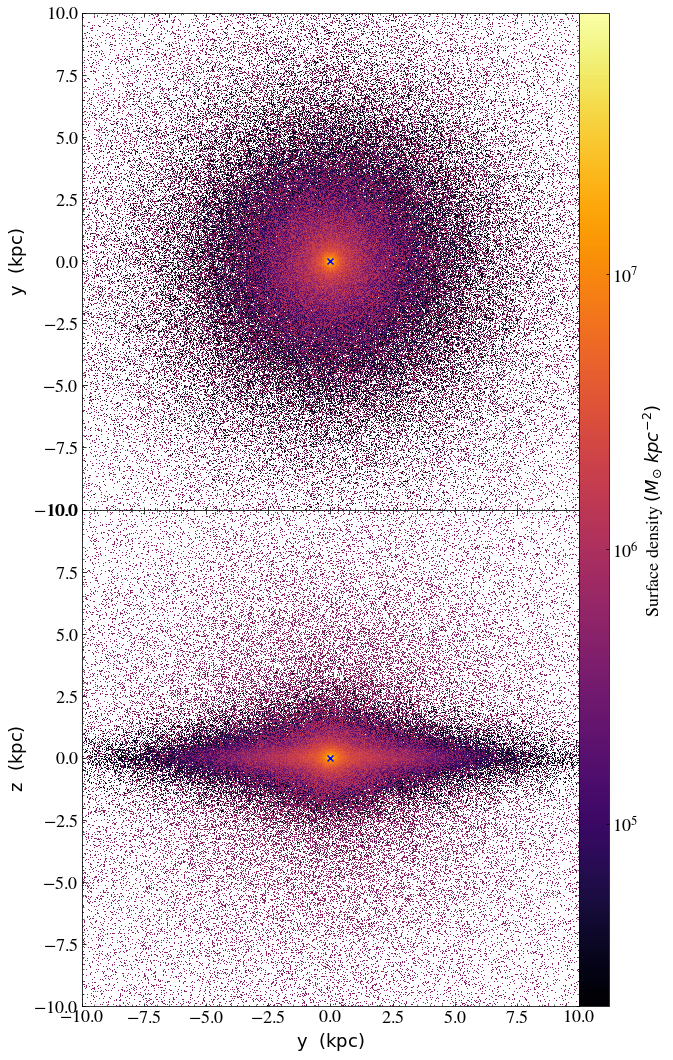

In [5]:
import yt
import glob
from yt.units import kpc
from yt import load_particles
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import gridspec

# Redifining the units
unit_base = {'UnitLength_in_cm'         : 3.08568e+21,
             'UnitMass_in_g'            :   1.989e+33,
             'UnitVelocity_in_cm_per_s' :      100000}

bbox_lim = 5.0e10 # limit box in kpc

# Adjusting the size of the box
bbox = [[-bbox_lim,bbox_lim],
        [-bbox_lim,bbox_lim],
        [-bbox_lim,bbox_lim]]

# here we are plotting ALL particle types, howerver, YT allows to plot independently each particle type as follows:
# 1. DM halo: PartType1
# 2. Thin-disc: PartType2
# 3. Bulge + Nucleus: PartType3
# 4. NSD: PartType4
# 5. Thick-disc: PartType5

Type = 'all'
file = 'data/FCC170_test_model.hdf5'
size = 20.0

fig = plt.figure(1, (5, 10))
gs  = gridspec.GridSpec(2, 1, width_ratios=[3])
grid = AxesGrid(fig, (1.5,1.5,1.5,1.5),
                nrows_ncols = (2, 1),
                axes_pad = 0.,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

ds = yt.load(file,unit_base=unit_base,bounding_box=bbox)
ad   = ds.all_data()

# Locating the central SMBH as we want to mark its position on the plots
where = ad[('PartType4','Masses')].value.argmax()
posx, posy, posz = ad[('PartType4','Coordinates')].value[where,0], ad[('PartType4','Coordinates')].value[where,1], ad[('PartType4','Coordinates')].value[where,2]

p = yt.ParticlePlot(ds, (Type,'particle_position_x'),(Type,'particle_position_y'),
                                (Type,'Masses'))
p.set_width(size, 'kpc')
p.set_cmap(field=(Type,'Masses'), cmap='inferno')
p.set_unit('Masses', 'Msun')
p.set_colorbar_label((Type,'Masses'),r'Surface density $(M_{\odot}$ $kpc^{-2})$')
p.set_log('Masses', True)
p.annotate_marker((posx, posy), coord_system='plot', plot_args={'color':'blue'}) # Central SMBH face-on

plot        = p.plots['Masses']
plot.figure = fig
plot.axes   = grid[0].axes
plot.cax    = grid.cbar_axes[0]
    
# Finally, redraw the plot on the AxesGrid axes.
p._setup_plots()
    
p = yt.ParticlePlot(ds, (Type,'particle_position_y'),(Type,'particle_position_z'),
                                (Type,'Masses'))
p.set_width(size, 'kpc')
p.set_cmap(field=(Type,'Masses'), cmap='inferno')
p.set_unit('Masses', 'Msun')
p.set_colorbar_label((Type,'Masses'),r'Surface density $(M_{\odot}$ $kpc^{-2})$')
p.set_log('Masses', True)
p.annotate_marker((posy, posz), coord_system='plot', plot_args={'color':'blue'}) # Central SMBH edge-on

plot        = p.plots['Masses']
plot.figure = fig
plot.axes   = grid[1].axes
plot.cax    = grid.cbar_axes[1]

p._setup_plots()

## 3. Kinematics comparison: observations vs N-body model

Let's see how the kinematics of our N-body model looks like. For this purpose, we consider the kinematics obtained via pPXF algorithm (Cappellari et al. 2004 and 2017) which applyes a set of stellar templates over a voronoi bin convolved with a multiplicative/aditive polynomial to fit a spectra. This method provides the different momenta of kinematics (e.g. line-of-sight velocity distribution, velocity dispersion, skewness and kurtosis) over each bin. In this regards, Pinna et al. 2019 (a and b) applyed this procedure to estimate the kinematics over three edge-on Fornax galaxies, in particular, FCC 170. The list of bins with their assigned kinematics is on folder data/FCC170_pPXF_kinematics_SNR_40.fits. Coming back to our N-body model, we can use the pPXF voronoi bin positions over our N-body model (in edge-on projection) to assign the average velocity of each cluster of particles that fall within a bin. For the velocity dispersion, we just need to take the velocity distribution in each bin and estimate the standard deviation (or the robust sigma).

Let's define the function to assign the voronoi bin grid to our N-body model:

In [7]:
def voronoi_bin(file,xx,yy,vel,mass):
    from astropy.table import Table
    from astropy.io import ascii, fits
    from tqdm import tqdm
    import pdb
    
    file_aux = file
    vel_voronoi = np.zeros_like(vel) # Here we store the LOSVD of our N-body model
    sig_voronoi = np.zeros_like(vel) # Here we store the velocity dispersion of our N-body model
    
    def robust_sigma(y, zero=False):
        """
        Biweight estimate of the scale (standard deviation).
        Implements the approach described in
        "Understanding Robust and Exploratory Data Analysis"
        Hoaglin, Mosteller, Tukey ed., 1983, Chapter 12B, pg. 417

        """
        y = np.ravel(y)
        d = y if zero else y - np.nanmedian(y)

        mad = np.nanmedian(np.abs(d))
        u2 = (d/(9.0*mad))**2  # c = 9
        good = u2 < 1.0
        u1 = 1.0 - u2[good]
        num = y.size * ((d[good]*u1**2)**2).sum()
        den = (u1*(1.0 - 5.0*u2[good])).sum()
        sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference

        return sigma
    
    alpha = -319.0 # This is the PA of the galaxy in degrees
    file = 'data/FCC170_pPXF_kinematics_SNR-40.fits'

    # Getting the different data from the pPXF.fits file
    hdu = fits.open(file,ignore_missing_end=True)[1].data
    
    # BIN positions
    x  = hdu.XBIN
    y  = hdu.YBIN
    
    # Line-of-sight velocity distribution and velocity dispersion
    vbin  = hdu.V
    sigma = hdu.SIGMA
    
    # Flux
    flux  = hdu.FLUXBIN
    
    ang = np.radians(alpha-90.0) # Converting the PA to radians

    xbin,ybin = x*np.cos(ang) - y*np.sin(ang), x*np.sin(ang) + y*np.cos(ang) # Now we rotate the galaxy to stay aligned

    # Defining the coordinates respect to the center of the galaxy
    good = sigma < 200.0 # We do not trust all those values above 200 velocity dispersion
    xbin, ybin, vbin, flux, sigma = xbin[good], ybin[good], vbin[good], flux[good], sigma[good]
    
    # Getting the centre of the galaxy
    idx = flux.argmax()
    xbin, ybin = xbin - xbin[idx], ybin - ybin[idx]
    rad = np.sqrt(xbin**2+ybin**2)
    idx = rad <= 1.0
    vbin = vbin - np.mean(vbin[idx]) # Subtracting the systemic velocity to change into the rest-frame of the galaxy

    where = (vbin >= -300.0) & (vbin <= 300.0) # We apply another filter
    xbin, ybin, vbin, flux, sigma = xbin[where], ybin[where], vbin[where], flux[where], sigma[where]

    # And now we define different zero arrays to store values
    d_to_bin = np.zeros(len(xx))
    Vs_mod   = np.ones(len(xbin)) # Velocity of the closest star
    Ss_mod   = np.ones(len(xbin)) # Sigma for each voronoi bins on the N-body model
    bin_ID   = []
    vel_mod  = np.zeros(len(xx))
    disp_mod = np.zeros(len(xx))

    ''' We require to assign each particle in our N-body model to each bin. For these, we find
    the closest bin to each particle.'''
    
    print('\n- Computing the closest BIN for each N-body particle -')
    for i in tqdm(range(len(xx))):
            r_tmp = np.sqrt((xbin-xx[i])**2+(ybin-yy[i])**2)
            d_to_bin[i] = min(r_tmp)
            bin_ID.append(r_tmp.argmin())

    k = np.where(d_to_bin > 5.0) # Neglecting those particles further away than bin by a distance > 5 arcsec     
        
    hists = np.zeros_like(xbin) # This array stores the velocity distribution in each bin
    
    ''' For each bin, we now should have a cluster of particles. We consider the average of the velocity distribution to 
    assign a single velocity for each bin, and we apply robust_sigma function in order to estimate the velocity dispersion
    in each bin.'''
    
    print('\n- Assigning kinematics to each BIN -')
    for i in tqdm(range(len(xbin))):
        idx = np.where(np.array(bin_ID) == i)[0]
        Vs_mod[i]  = np.nansum(vel[idx]*mass[idx])/np.nansum(mass[idx])
        Ss_mod[i]  = robust_sigma(vel[idx])
        hists[i]   = len(vel[idx])    
        
    ''' The last step is to come back from bins to particles. This is a simple process as we just require to
    get the average velocities we have in each bin, and re-assign them for their corresponding particles.'''    
        
    print('\n- Getting back the values of the binned kinematics to each particle -')
    for i in tqdm(range(len(xx))): 
        vel_mod[i]     = Vs_mod[bin_ID[i]]
        disp_mod[i]    = Ss_mod[bin_ID[i]]
        vel_voronoi[i] = vbin[bin_ID[i]]
        sig_voronoi[i] = sigma[bin_ID[i]]
        
    # Neglecting those particles which fall further away than 5 arcsecs from a bin
    vel_mod[k] = np.nan; disp_mod[k] = np.nan
    vel_voronoi[k] = np.nan; sig_voronoi[k] = np.nan        
    
    return vel_mod, disp_mod, vel_voronoi, sig_voronoi

To run our vornoi-bin assignment routine, we need to read the coordinates and velocities of the particles. Keep in mind we have to exclude the dark matter particles as they cannot be 'observed', so in the assignment we just use the particles corresponding to the 'stellar components' (all but PartType1).

In [8]:
snapshot  = 'data/FCC170_test_model.hdf5'    
      
ds = yt.load(snapshot,unit_base=unit_base,bounding_box=bbox)
ad = ds.all_data()
    
# Extracting the coordinates and velocities of the particles
pos1 = ad[('PartType2','Coordinates')]; vel1 = ad[('PartType2','Velocities')]; mass1 = ad[('PartType2','Masses')]
pos2 = ad[('PartType3','Coordinates')]; vel2 = ad[('PartType3','Velocities')]; mass2 = ad[('PartType3','Masses')]
pos3 = ad[('PartType4','Coordinates')]; vel3 = ad[('PartType4','Velocities')]; mass3 = ad[('PartType4','Masses')]
pos4 = ad[('PartType5','Coordinates')]; vel4 = ad[('PartType5','Velocities')]; mass4 = ad[('PartType5','Masses')]

pos, vel, id, mass = [], [], [], []
pos.extend(pos1); vel.extend(vel1); mass.extend(mass1)
pos.extend(pos2); vel.extend(vel2); mass.extend(mass2)
pos.extend(pos3); vel.extend(vel3); mass.extend(mass3)
pos.extend(pos4); vel.extend(vel4); mass.extend(mass4)
pos, vel, mass = np.array(pos), np.array(vel), np.array(mass)

data = np.zeros([len(pos),4])
        
data[:,0] = pos[:,1]; data[:,1] = pos[:,2]; data[:,2] = vel[:,0]; data[:,3] = mass
 
# Using the existing Voronoi-bin kinematics to fit our data
vel_mod, sigma_mod, vel_voronoi, sig_voronoi = voronoi_bin(snapshot,data[:,0]/0.1,data[:,1]/0.1,data[:,2],data[:,3])  

yt : [INFO     ] 2021-06-14 12:29:22,847 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2021-06-14 12:29:22,858 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-06-14 12:29:22,859 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-06-14 12:29:22,859 Parameters: domain_left_edge          = [-5.e+10 -5.e+10 -5.e+10]
yt : [INFO     ] 2021-06-14 12:29:22,860 Parameters: domain_right_edge         = [5.e+10 5.e+10 5.e+10]
yt : [INFO     ] 2021-06-14 12:29:22,861 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2021-06-14 12:29:22,864 Allocating for 1.700e+06 particles (index particle type 'all')
yt : [INFO     ] 2021-06-14 12:29:23,056 Identified 1.225e+03 octs



- Computing the closest BIN for each N-body particle -


100%|██████████| 1200001/1200001 [19:13<00:00, 1039.88it/s]



- Assigning kinematics to each BIN -


100%|██████████| 10294/10294 [12:58<00:00, 13.22it/s]



- Getting back the values of the binned kinematics to each particle -


100%|██████████| 1200001/1200001 [00:01<00:00, 1076151.23it/s]


And finally, we make some plots

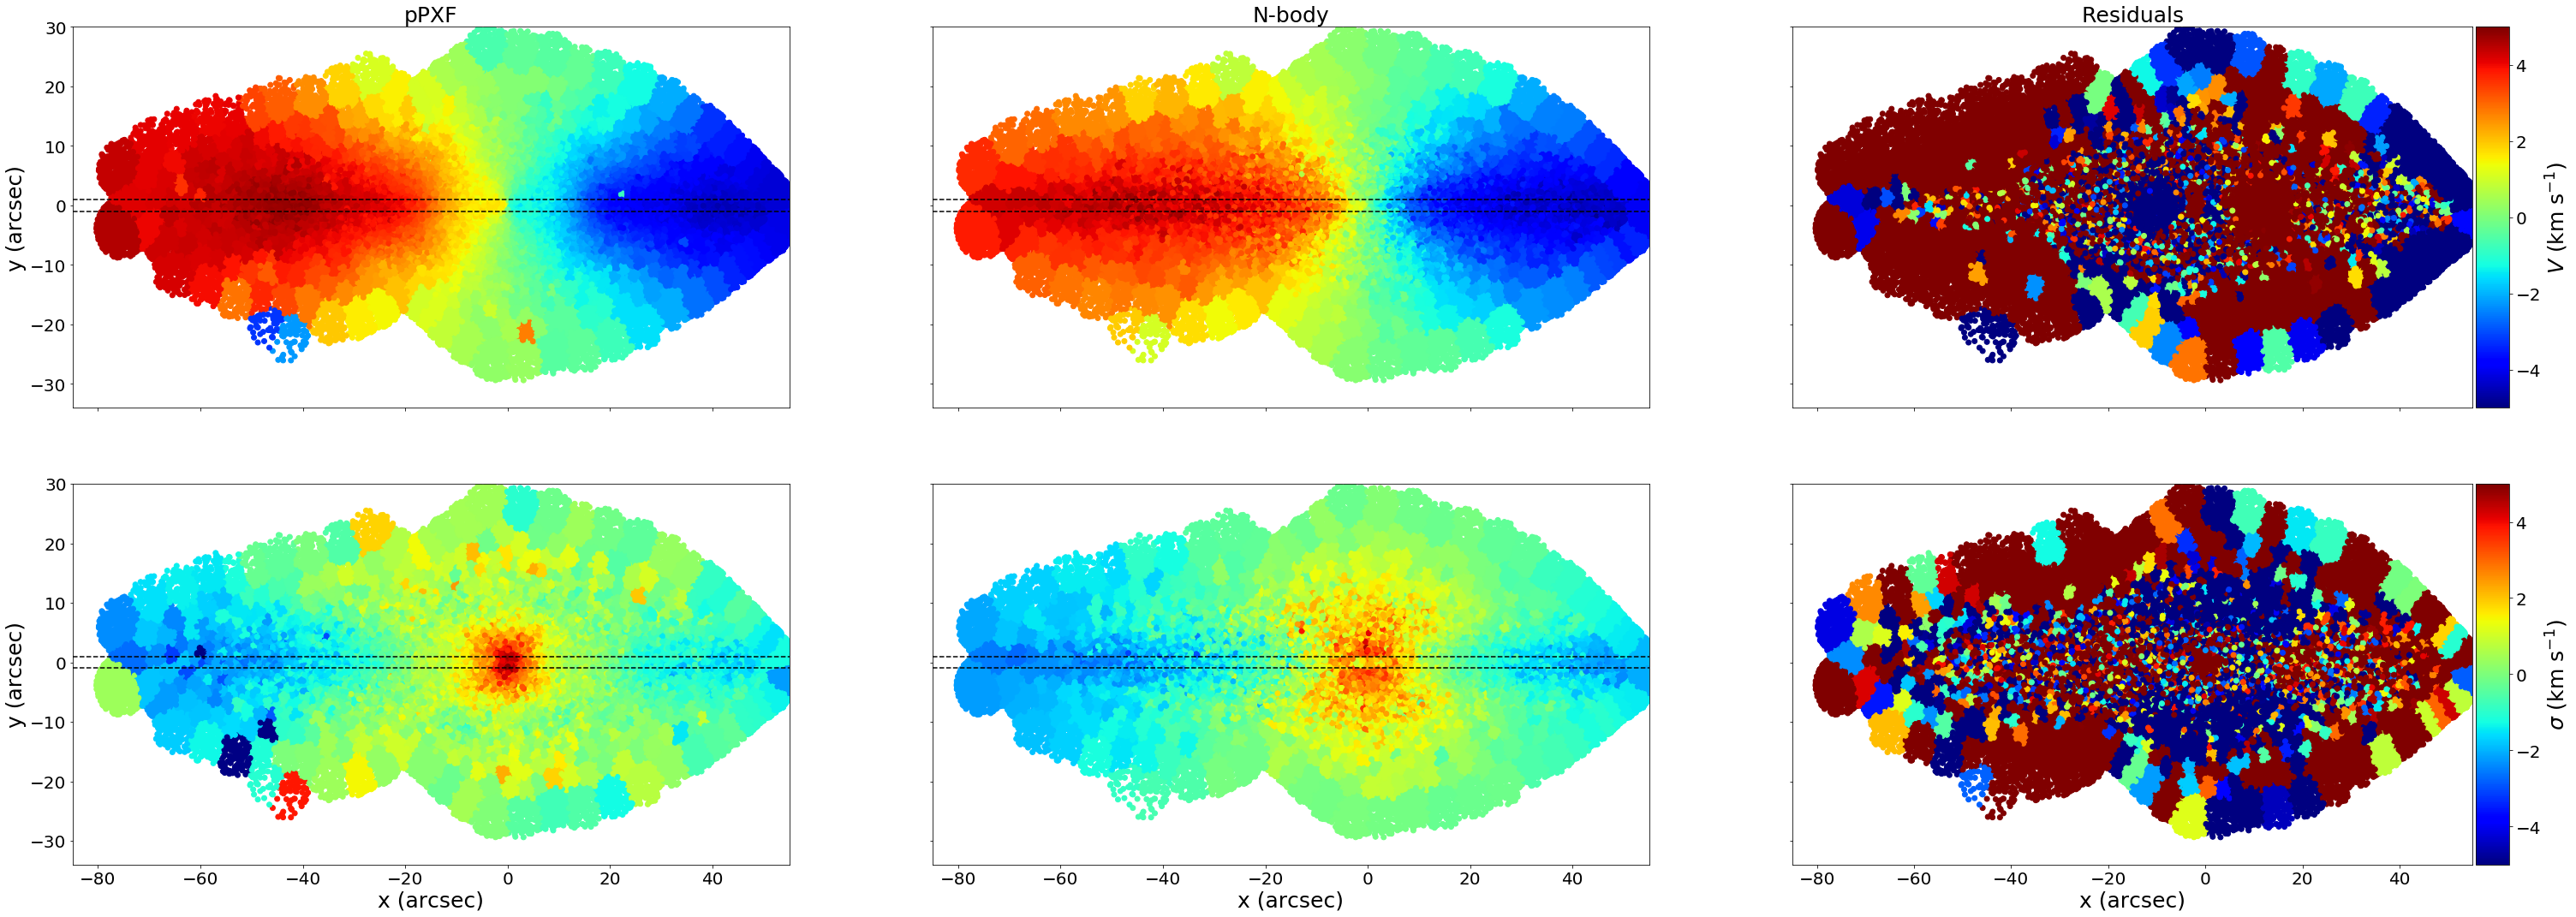

In [9]:
ang = np.radians(0.0)
xcord, ycord = data[:,0]*np.cos(ang) + data[:,1]*np.sin(ang), -data[:,0]*np.sin(ang) + data[:,1]*np.cos(ang)

eps = 1.0 # Thickness of the aperture along the major axis in kpc

fig, ax = plt.subplots(2,3,figsize=(51,18))
ax = ax.ravel()

im1 = ax[0].scatter(xcord/0.1,ycord/0.1,c=vel_voronoi,cmap='jet',vmin=-180,vmax=180)
im2 = ax[1].scatter(xcord/0.1,ycord/0.1,c=vel_mod,cmap='jet',vmin=-180,vmax=180)
im3 = ax[2].scatter(xcord/0.1,ycord/0.1,c=vel_voronoi-vel_mod,cmap='jet',vmin=-5,vmax=5)
ax[0].set_xlim(-85,55); ax[0].set_ylim(-34,30)
ax[1].set_xlim(-85,55); ax[1].set_ylim(-34,30)
ax[2].set_xlim(-85,55); ax[2].set_ylim(-34,30)

ax[0].set_xticklabels( () ); ax[1].set_xticklabels( () ); ax[2].set_xticklabels( () )
ax[0].tick_params(axis='x',labelsize=20); ax[0].tick_params(axis='y',labelsize=20)
ax[1].tick_params(axis='x',labelsize=20); ax[1].tick_params(axis='y',labelsize=20)
ax[2].tick_params(axis='x',labelsize=20); ax[2].tick_params(axis='y',labelsize=20)

im4 = ax[3].scatter(xcord/0.1,ycord/0.1,c=sig_voronoi,cmap='jet',vmin=0.,vmax=160.0)
im5 = ax[4].scatter(xcord/0.1,ycord/0.1,c=sigma_mod,cmap='jet',vmin=0.,vmax=160.0)
im6 = ax[5].scatter(xcord/0.1,ycord/0.1,c=sig_voronoi-sigma_mod,cmap='jet',vmin=-5.,vmax=5.)
ax[3].set_xlim(-85,55); ax[3].set_ylim(-34,30)
ax[4].set_xlim(-85,55); ax[4].set_ylim(-34,30)
ax[5].set_xlim(-85,55); ax[5].set_ylim(-34,30)

ax[1].set_yticklabels( () ); ax[2].set_yticklabels( () ); ax[4].set_yticklabels( () )
ax[5].set_yticklabels( () )
ax[3].tick_params(axis='x',labelsize=20); ax[3].tick_params(axis='y',labelsize=20)
ax[4].tick_params(axis='x',labelsize=20); ax[4].tick_params(axis='y',labelsize=20)
ax[5].tick_params(axis='x',labelsize=20); ax[5].tick_params(axis='y',labelsize=20)

#divider = make_axes_locatable(ax[0])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
#cb1 = fig.colorbar(im1, cax=cax, orientation='vertical')
#cb1.set_label(label=r'$V$ (km s$^{-1}$)',fontsize=25)
ax[0].set_ylabel('y (arcsec)', fontsize=25)
ax[0].set_title('pPXF', fontsize=25)
#cb1.ax.tick_params(labelsize=20)

#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
#cb2 = fig.colorbar(im2, cax=cax, orientation='vertical')
#cb2.set_label(label=r'$V$ (km s$^{-1}$)',fontsize=25)
ax[1].set_title('N-body', fontsize=25)
#cb2.ax.tick_params(labelsize=20)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
cb3 = fig.colorbar(im3, cax=cax, orientation='vertical')
cb3.set_label(label=r'$V$ (km s$^{-1}$)',fontsize=25)
ax[2].set_title('Residuals', fontsize=25)
cb3.ax.tick_params(labelsize=20)

#divider = make_axes_locatable(ax[3])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
#cb4 = fig.colorbar(im4, cax=cax, orientation='vertical')
#cb4.set_label(label=r'$\sigma$ (km s$^{-1}$)',fontsize=25)
ax[3].set_xlabel('x (arcsec)', fontsize=25); ax[3].set_ylabel('y (arcsec)', fontsize=25)
#cb4.ax.tick_params(labelsize=20)

#divider = make_axes_locatable(ax[4])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
#cb5 = fig.colorbar(im5, cax=cax, orientation='vertical')
#cb5.set_label(label=r'$\sigma$ (km s$^{-1}$)',fontsize=25)
ax[4].set_xlabel('x (arcsec)', fontsize=25)
#cb5.ax.tick_params(labelsize=20)

divider = make_axes_locatable(ax[5])
cax = divider.append_axes('right', size='5%', pad=0.05)
#ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
cb6 = fig.colorbar(im6, cax=cax, orientation='vertical')
cb6.set_label(label=r'$\sigma$ (km s$^{-1}$)',fontsize=25)
ax[5].set_xlabel('x (arcsec)', fontsize=25)
cb6.ax.tick_params(labelsize=20)

ax[0].axhline(eps,color='black',linestyle='dashed'); ax[0].axhline(-eps,color='black',linestyle='dashed')
ax[1].axhline(eps,color='black',linestyle='dashed'); ax[1].axhline(-eps,color='black',linestyle='dashed')
ax[3].axhline(eps,color='black',linestyle='dashed'); ax[3].axhline(-eps,color='black',linestyle='dashed')
ax[4].axhline(eps,color='black',linestyle='dashed'); ax[4].axhline(-eps,color='black',linestyle='dashed')
plt.savefig('FCC170_kinematics_0Myr.png')

Let's make more representative plots of how much precise is our model kinematics compared to the pPXF one. It is useful to plot the radial profiles of either LOSVD and velocity dispersion by getting the LOSVD along the major-axis (otherwise along the minor axis):

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


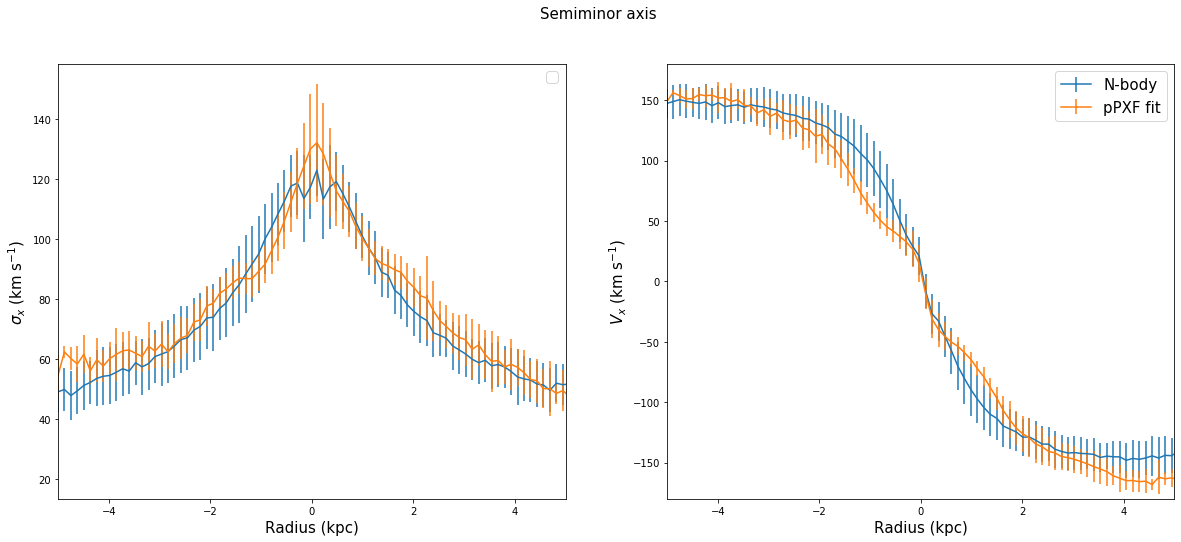

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
fig.suptitle('Semiminor axis', fontsize=15)
ax = ax.ravel()

alpha = -310.0 + 180.0 # Position angle of the galaxy in degrees

# Getting the pPXF data from the table
file = 'data/FCC170_pPXF_kinematics_SNR-40.fits'
x  = fits.open(file)[1].data.XBIN
y  = fits.open(file)[1].data.YBIN
vbin  = fits.open(file)[1].data.V
sigma = fits.open(file)[1].data.SIGMA
flux  = fits.open(file)[1].data.FLUXBIN
ang = np.radians(alpha-90.0)

xbin,ybin = x*np.cos(ang) - y*np.sin(ang), x*np.sin(ang) + y*np.cos(ang)

# Neglecting to pixels with consistent velocity dispersion
good = sigma < 200.0
xbin, ybin, vbin, flux, sigma = xbin[good], ybin[good], vbin[good], flux[good], sigma[good]

# Defining the coordinates respect to the center of the galaxy by considering the brightest bin
idx = flux.argmax()
xbin, ybin = xbin - xbin[idx], ybin - ybin[idx]

# Now we subtract the mean velocity from the centre
rad = np.sqrt(xbin**2+ybin**2)
idx = rad <= 1.0
vbin = vbin - np.mean(vbin[idx])

# Discarding all those bins with v > |300| km/s
where = (vbin >= -300.0) & (vbin <= 300.0)
xbin, ybin, vbin, flux, sigma = xbin[where], ybin[where], vbin[where], flux[where], sigma[where]

radbin = np.sqrt(xbin**2+ybin**2) # Radius of the bins

''' In this loop we store the values of either the LOSVD and the velocity dispersion
    in each aperture in our N-body model. As we are considering average values along the major axis of the galactic plane,
    we need to constrain to the thickness given by eps parameter in a rectangular aperture of size between
    R(i) and R(i+1). The errors are given by the scatter values in each bin. '''

vel_aux = np.array(vel_mod)
vel, sig = [], []
vel_err, sig_err = [],[]
yy, zz, vv, ss  = np.copy(xcord), np.copy(ycord), np.copy(vel_aux), np.copy(sigma_mod)
radap = np.linspace(min(xbin)*0.1,max(xbin)*0.1,100)
for i in range(len(radap)-1):
    filter = (zz <= eps) & (zz >= -eps)
    yy, zz, vv, ss = yy[filter], zz[filter], vv[filter], ss[filter]
    idx  = (yy >= radap[i]) & (yy <= radap[i+1])
    vel.append(np.nanmean(np.array([vv[idx]],dtype=np.float64)))
    vel_err.append(np.std(vv[idx][~np.isnan(vv[idx])]))
    sig.append(np.nanmean(ss[idx]))
    sig_err.append(np.std(ss[idx][~np.isnan(ss[idx])]))

ax[0].errorbar(radap[1:],sig,yerr=sig_err)#,label='N-body')
ax[1].errorbar(np.array(radap[1:]),np.array(vel),yerr=np.array(vel_err),label='N-body')

velbin, sigbin = [], []
velbin_err, sigbin_err = [],[]
radap = np.linspace(min(xbin)*0.1,max(xbin)*0.1,100)
for i in range(len(radap)-1):
    filter = (ybin*0.1 <= eps) & (ybin*0.1 >= -eps)
    xbin, vbin, sigma, ybin = xbin[filter], vbin[filter], sigma[filter], ybin[filter]
    idx  = (xbin*0.1 >= radap[i]) & (xbin*0.1 <= radap[i+1])
    velbin.append(np.nanmean(vbin[idx]))
    velbin_err.append(np.std(vbin[idx]))
    sigbin.append(np.nanmean(sigma[idx]))
    sigbin_err.append(np.std(sigma[idx]))
    
ax[0].errorbar(radap[1:],sigbin,yerr=sigbin_err)#,label='pPXF fit')
ax[1].errorbar(radap[1:],-np.array(velbin),yerr=-np.array(velbin_err),label='pPXF fit')
    
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)

ax[0].set_xlabel('Radius (kpc)', fontsize=15); ax[0].set_ylabel(r'$\sigma_{x}$ (km s$^{-1}$)', fontsize=15)
ax[1].set_xlabel('Radius (kpc)', fontsize=15); ax[1].set_ylabel(r'$V_{x}$ (km s$^{-1}$)', fontsize=15)

ax[0].set_xlim(-5.0,5.0); ax[1].set_xlim(-5.0,5.0);
ax[1].set_ylim(-180.0,180.0)
plt.savefig('FCC170_kinematics_major.png')

/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/pgdeanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


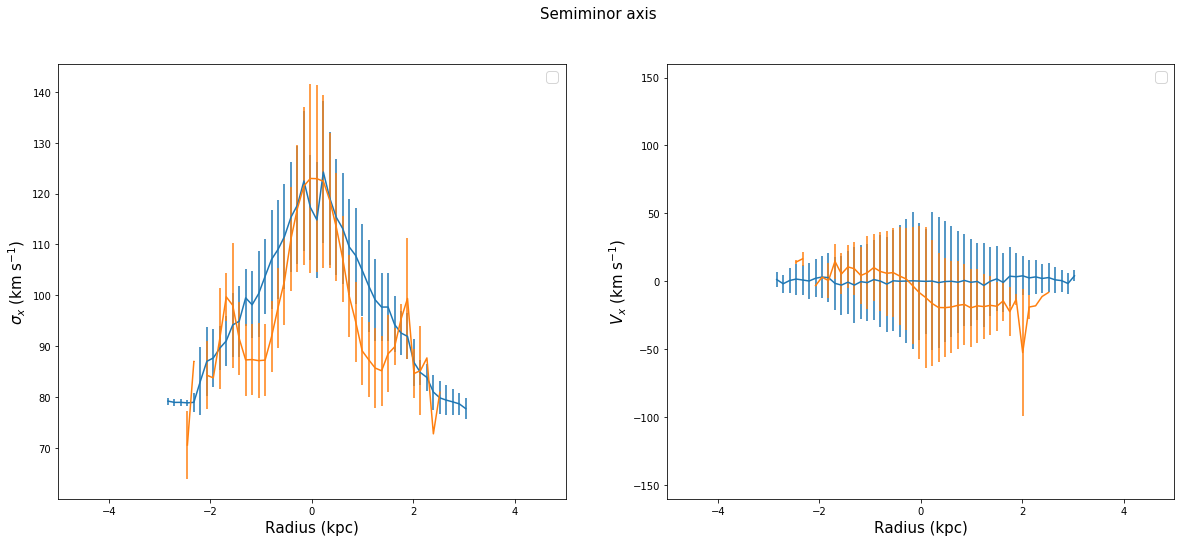

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
fig.suptitle('Semiminor axis', fontsize=15)
ax = ax.ravel()

alpha = -310.0 + 180.0 # Position angle of the galaxy in degrees

# Getting the pPXF data from the table
file = 'data/FCC170_pPXF_kinematics_SNR-40.fits'
x  = fits.open(file)[1].data.XBIN
y  = fits.open(file)[1].data.YBIN
vbin  = fits.open(file)[1].data.V
sigma = fits.open(file)[1].data.SIGMA
flux  = fits.open(file)[1].data.FLUXBIN
ang = np.radians(alpha-90.0)

xbin,ybin = x*np.cos(ang) - y*np.sin(ang), x*np.sin(ang) + y*np.cos(ang)

# Neglecting to pixels with consistent velocity dispersion
good = sigma < 200.0
xbin, ybin, vbin, flux, sigma = xbin[good], ybin[good], vbin[good], flux[good], sigma[good]

# Defining the coordinates respect to the center of the galaxy by considering the brightest bin
idx = flux.argmax()
xbin, ybin = xbin - xbin[idx], ybin - ybin[idx]

# Now we subtract the mean velocity from the centre
rad = np.sqrt(xbin**2+ybin**2)
idx = rad <= 1.0
vbin = vbin - np.mean(vbin[idx])

# Discarding all those bins with v > |300| km/s
where = (vbin >= -300.0) & (vbin <= 300.0)
xbin, ybin, vbin, flux, sigma = xbin[where], ybin[where], vbin[where], flux[where], sigma[where]

radbin = np.sqrt(xbin**2+ybin**2) # Radius of the bins

''' In this loop we store the values of either the LOSVD and the velocity dispersion
    in each aperture in our N-body model. As we are considering average values along the major axis of the galactic plane,
    we need to constrain to the thickness given by eps parameter in a rectangular aperture of size between
    R(i) and R(i+1). The errors are given by the scatter values in each bin. '''

vel_aux = np.array(vel_mod)
vel, sig = [], []
vel_err, sig_err = [],[]
yy, zz, vv, ss  = np.copy(xcord), np.copy(ycord), np.copy(vel_aux), np.copy(sigma_mod)
radap = np.linspace(min(xbin)*0.1,max(xbin)*0.1,100)
for i in range(len(radap)-1):
    filter = (yy <= eps) & (yy >= -eps)
    yy, zz, vv, ss = yy[filter], zz[filter], vv[filter], ss[filter]
    idx  = (zz >= radap[i]) & (zz <= radap[i+1])
    vel.append(np.nanmean(np.array([vv[idx]],dtype=np.float64)))
    vel_err.append(np.std(vv[idx][~np.isnan(vv[idx])]))
    sig.append(np.nanmean(ss[idx]))
    sig_err.append(np.std(ss[idx][~np.isnan(ss[idx])]))

ax[0].errorbar(radap[1:],sig,yerr=sig_err)#,label='N-body')
ax[1].errorbar(np.array(radap[1:]),np.array(vel),yerr=np.array(vel_err))

velbin, sigbin = [], []
velbin_err, sigbin_err = [],[]
radap = np.linspace(min(xbin)*0.1,max(xbin)*0.1,100)
for i in range(len(radap)-1):
    filter = (xbin*0.1 <= eps) & (xbin*0.1 >= -eps)
    xbin, vbin, sigma, ybin = xbin[filter], vbin[filter], sigma[filter], ybin[filter]
    idx  = (ybin*0.1 >= radap[i]) & (ybin*0.1 <= radap[i+1])
    velbin.append(np.nanmean(vbin[idx]))
    velbin_err.append(np.std(vbin[idx]))
    sigbin.append(np.nanmean(sigma[idx]))
    sigbin_err.append(np.std(sigma[idx]))
    
ax[0].errorbar(radap[1:],sigbin,yerr=sigbin_err)#,label='pPXF fit')
ax[1].errorbar(radap[1:],-np.array(velbin),yerr=-np.array(velbin_err))#,label='pPXF fit')
    
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)

ax[0].set_xlabel('Radius (kpc)', fontsize=15); ax[0].set_ylabel(r'$\sigma_{x}$ (km s$^{-1}$)', fontsize=15)
ax[1].set_xlabel('Radius (kpc)', fontsize=15); ax[1].set_ylabel(r'$V_{x}$ (km s$^{-1}$)', fontsize=15)

ax[0].set_xlim(-5.0,5.0); ax[1].set_xlim(-5.0,5.0);
ax[1].set_ylim(-160.0,160.0)
plt.savefig('FCC170_kinematics_minor.png')